## MODEL CALIBRATION IMPLEMENTATION

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import time
from tensorflow import keras

# CALIBRATION LIBRARIES
import tensorflow_probability as tfp
from netcal.metrics import ECE
from netcal.scaling import TemperatureScaling
from netcal.presentation import ReliabilityDiagram

In [2]:
FOLDERPATH = '../'

In [3]:
'''
LOAD DATA
'''
data_path = FOLDERPATH+'old-data/'
train_data = pd.read_csv(data_path+'v3.2.2_train.csv')
test_data = pd.read_csv(data_path+'test.csv')

y_train,y_test = train_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']], test_data[['TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow']]
X_train,X_test = train_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow'],axis=1),test_data.drop(['Unnamed: 0','TOT_fast','TOT_med_fast','TOT_med','TOT_med_slow','TOT_slow'],axis=1)

In [6]:
def define_model(xshape):
    input_layer = keras.layers.Input(shape=(xshape,))
    dense_1 = keras.layers.Dense(28, activation='relu', kernel_initializer='he_normal')(input_layer)
    dense_2 = keras.layers.Dense(14, activation='relu')(dense_1)
    dense_3 = keras.layers.Dense(8, activation='relu')(dense_2)
    logits = keras.layers.Dense(5)(dense_3) 
    model = keras.Model(inputs=input_layer, outputs=logits)
    
    loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
    
    return model

def save_model(model,fname):
    model_path = FOLDERPATH+'attribution-models/'
    model.save(model_path+fname)

def save_history(history,fname):
    with open(FOLDERPATH+'attribution-models/'+fname,'wb') as f:
        pkl.dump(history,f)
    f.close()

In [7]:
# fit the keras model on the dataset
model = define_model(X_train.shape[1])
history = model.fit(X_train.values, y_train.values,
                      validation_split=0.10,
                      epochs=50,
                      batch_size=16)

save_model(model,'model_for_calibration.h5')

Epoch 1/50
60002/60002 [==============================] - 51s 851us/step - loss: 0.8102 - accuracy: 0.6724 - val_loss: 0.6612 - val_accuracy: 0.7413
Epoch 2/50
60002/60002 [==============================] - 45s 749us/step - loss: 0.6207 - accuracy: 0.7586 - val_loss: 0.5844 - val_accuracy: 0.7761
Epoch 3/50
60002/60002 [==============================] - 46s 772us/step - loss: 0.5590 - accuracy: 0.7847 - val_loss: 0.5385 - val_accuracy: 0.7956
Epoch 4/50
60002/60002 [==============================] - 44s 740us/step - loss: 0.5206 - accuracy: 0.8006 - val_loss: 0.5057 - val_accuracy: 0.8079
Epoch 5/50
60002/60002 [==============================] - 43s 723us/step - loss: 0.4963 - accuracy: 0.8118 - val_loss: 0.4921 - val_accuracy: 0.8133
Epoch 6/50
60002/60002 [==============================] - 44s 735us/step - loss: 0.4801 - accuracy: 0.8179 - val_loss: 0.4715 - val_accuracy: 0.8238
Epoch 7/50
60002/60002 [==============================] - 44s 730us/step - loss: 0.4675 - accuracy: 0.8237

In [4]:
# LOAD TRAINED MODEL
model = load_model(FOLDERPATH+'attribution-models/model_for_calibration.h5')

### USING THE TENSORFLOW-PROBABILITY PACKAGE

In [20]:
y_pred = model.predict(X_test)

num_bins = 10
labels_true = tf.convert_to_tensor(y_test.values.argmax(axis=1), dtype=tf.int32, name='labels_true')
logits = tf.convert_to_tensor(y_pred, dtype=tf.float32, name='logits')

tf.print("Calibration Error before calibration: ",tfp.stats.expected_calibration_error(num_bins=num_bins, 
                                     logits=logits, 
                                     labels_true=labels_true))

Calibration Error before calibration:  0.0117230676


In [21]:
temp = tf.Variable(initial_value=1.0, trainable=True, dtype=tf.float32) 

def compute_loss():
    y_pred_model_w_temp = tf.math.divide(y_pred, temp)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(\
                                tf.convert_to_tensor(y_test), y_pred_model_w_temp))
    return loss

optimizer = tf.optimizers.Adam(learning_rate=0.01)

print('Temperature Initial value: {}'.format(temp.numpy()))

for i in range(300):
    opts = optimizer.minimize(compute_loss, var_list=[temp])


print('Temperature Final value: {}'.format(temp.numpy()))

Temperature Initial value: 1.0
Temperature Final value: 1.0949934720993042


In [22]:
y_pred_model_w_temp = tf.math.divide(y_pred, temp)

num_bins = 10
labels_true = tf.convert_to_tensor(y_test.values.argmax(axis=1), dtype=tf.int32, name='labels_true')
logits = tf.convert_to_tensor(y_pred_model_w_temp, dtype=tf.float32, name='logits')

tf.print("Calibration Error after calibration:", tfp.stats.expected_calibration_error(num_bins=num_bins, 
                                     logits=logits, 
                                     labels_true=labels_true))

Calibration Error after calibration: 0.00968880858


### USING NETCAL PACKAGE

In [24]:
model = load_model(FOLDERPATH+'tot-models/latest/model.h5')

In [28]:
n_bins = 10

confidences = model.predict(X_test.values)
ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences,y_test.values.argmax(axis=1))
print("Calibration Error before calibration: ",uncalibrated_score)

Calibration Error before calibration:  0.009794939618186959


In [30]:
temperature = TemperatureScaling()
temperature.fit(confidences, y_test.values.argmax(axis=1))
calibrated = temperature.transform(confidences)
ece = ECE(n_bins)
calibrated_score = ece.measure(calibrated,y_test.values.argmax(axis=1))
print("Calibration Error after calibration: ",calibrated_score)

Calibration Error after calibration:  0.0032634920061256384


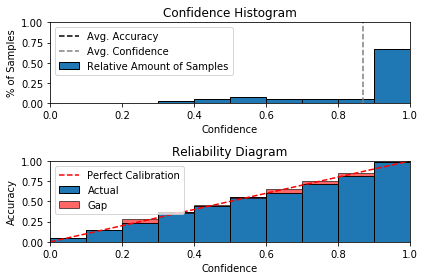

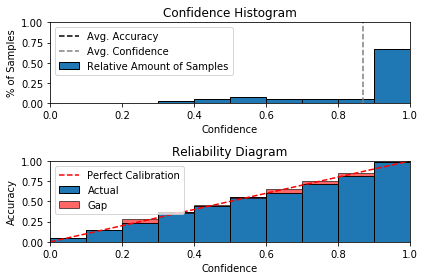

In [31]:
n_bins = 10

diagram = ReliabilityDiagram(n_bins)
diagram.plot(confidences, y_test.values.argmax(axis=1))  # visualize miscalibration of uncalibrated

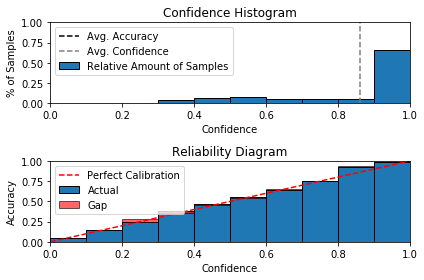

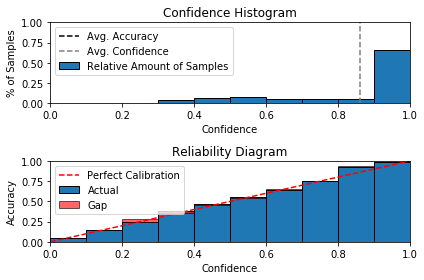

In [32]:
diagram.plot(calibrated, y_test.values.argmax(axis=1))   # visualize miscalibration of calibrated